# Parse Error Analysis (CORRECTED): Relationship with Code vs NL Trend

**IMPORTANT FIX**: The `code_parse_err` boolean field is misleading!
- Many records have `code_parse_err=True` but `code_err_msg="ok,ok"` AND `code_correct=True`
- We use `code_err_msg` to detect REAL errors:
  - "ok" or "ok,ok" → NO error
  - Empty string or other values → Error

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats as scipy_stats

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

RESULTS_DIR = Path("../results")

In [2]:
def has_real_error(err_msg):
    """Check if err_msg indicates a REAL error.
    
    Returns True if error, False if 'ok' (no error).
    """
    if not err_msg or err_msg == '':
        return True  # Empty = no response = error
    err_msg = str(err_msg).lower().strip()
    if err_msg in ['ok', 'ok,ok']:
        return False  # "ok" means no error
    return True

# Load all results
all_rows = []
for jsonl_path in RESULTS_DIR.rglob("res.jsonl"):
    with open(jsonl_path) as f:
        for line in f:
            try:
                row = json.loads(line)
                model = row.get('model', '').replace('openrouter/', '').replace('anthropic/', '').replace('google/', '').replace('openai/', '')
                if not model:
                    continue
                all_rows.append({
                    'model': model,
                    'nl_correct': row.get('nl_correct', False),
                    'code_correct': row.get('code_correct', False),
                    'sim_correct': row.get('sim_correct', False),
                    'nl_err': has_real_error(row.get('nl_err_msg', '')),
                    'code_err': has_real_error(row.get('code_err_msg', '')),
                    'sim_err': has_real_error(row.get('sim_err_msg', '')),
                })
            except:
                continue

df = pd.DataFrame(all_rows)
print(f"Loaded {len(df):,} rows")

Loaded 40,091 rows


## Per-Model Statistics (Corrected)

In [3]:
# Compute per-model stats with CORRECTED error detection
model_stats = []
for model, group in df.groupby('model'):
    if len(group) < 50:
        continue
    stats = {
        'model': model,
        'n': len(group),
        'nl_acc': group['nl_correct'].mean() * 100,
        'code_acc': group['code_correct'].mean() * 100,
        'sim_acc': group['sim_correct'].mean() * 100,
        'nl_err%': group['nl_err'].mean() * 100,
        'code_err%': group['code_err'].mean() * 100,
        'sim_err%': group['sim_err'].mean() * 100,
    }
    stats['code_vs_nl'] = stats['code_acc'] - stats['nl_acc']
    model_stats.append(stats)

stats_df = pd.DataFrame(model_stats).sort_values('code_vs_nl', ascending=False)
print(f"Computed stats for {len(stats_df)} models")

Computed stats for 32 models


In [4]:
# Display table
styled = stats_df.style.format({
    'nl_acc': '{:.1f}%', 'code_acc': '{:.1f}%', 'sim_acc': '{:.1f}%',
    'code_vs_nl': '{:+.1f}%',
    'nl_err%': '{:.1f}%', 'code_err%': '{:.1f}%', 'sim_err%': '{:.1f}%',
}).background_gradient(subset=['code_vs_nl'], cmap='RdYlGn', vmin=-50, vmax=50)
styled

,model,n,nl_acc,code_acc,sim_acc,nl_err%,code_err%,sim_err%,code_vs_nl
7,gemini-2.5-flash-lite,453,0.0%,50.8%,28.9%,100.0%,33.8%,0.0%,+50.8%
5,gemini-2.0-flash-001,1058,4.8%,39.7%,20.4%,62.0%,15.2%,0.0%,+34.9%
31,z-ai/glm-4.6,622,0.0%,22.8%,48.9%,100.0%,74.6%,9.2%,+22.8%
24,mistralai/mistral-large-2411,1058,0.8%,22.0%,21.6%,98.3%,37.0%,0.1%,+21.3%
14,gpt-oss-20b,1745,36.8%,55.5%,87.6%,60.2%,43.6%,3.8%,+18.6%
26,qwen/qwen-2.5-72b-instruct,732,0.0%,18.6%,29.8%,100.0%,79.5%,0.3%,+18.6%
1,claude-haiku-4.5,3206,45.4%,61.5%,36.2%,0.1%,11.5%,2.3%,+16.2%
8,gemini-2.5-pro,384,3.9%,18.8%,52.1%,95.3%,79.7%,28.6%,+14.8%
20,microsoft/phi-4-reasoning-plus,732,0.0%,13.0%,26.6%,100.0%,85.4%,8.1%,+13.0%
23,mistralai/ministral-14b-2512,8632,11.9%,23.6%,17.1%,45.1%,65.8%,20.5%,+11.7%


## Correlation Analysis (Corrected)

In [5]:
correlations = {}

r, p = scipy_stats.pearsonr(stats_df['code_err%'], stats_df['code_vs_nl'])
correlations['Code Err% vs Code>NL'] = {'r': r, 'p': p}

r, p = scipy_stats.pearsonr(stats_df['nl_err%'], stats_df['code_vs_nl'])
correlations['NL Err% vs Code>NL'] = {'r': r, 'p': p}

print("="*60)
print("CORRELATION ANALYSIS (CORRECTED error detection)")
print("="*60)
for name, vals in correlations.items():
    sig = "***" if vals['p'] < 0.001 else "**" if vals['p'] < 0.01 else "*" if vals['p'] < 0.05 else ""
    print(f"{name:<30}: r = {vals['r']:+.3f}, p = {vals['p']:.4f} {sig}")
print("\n* p < 0.05, ** p < 0.01, *** p < 0.001")

CORRELATION ANALYSIS (CORRECTED error detection)
Code Err% vs Code>NL          : r = -0.198, p = 0.2779 
NL Err% vs Code>NL            : r = +0.556, p = 0.0010 ***

* p < 0.05, ** p < 0.01, *** p < 0.001


## Visualization

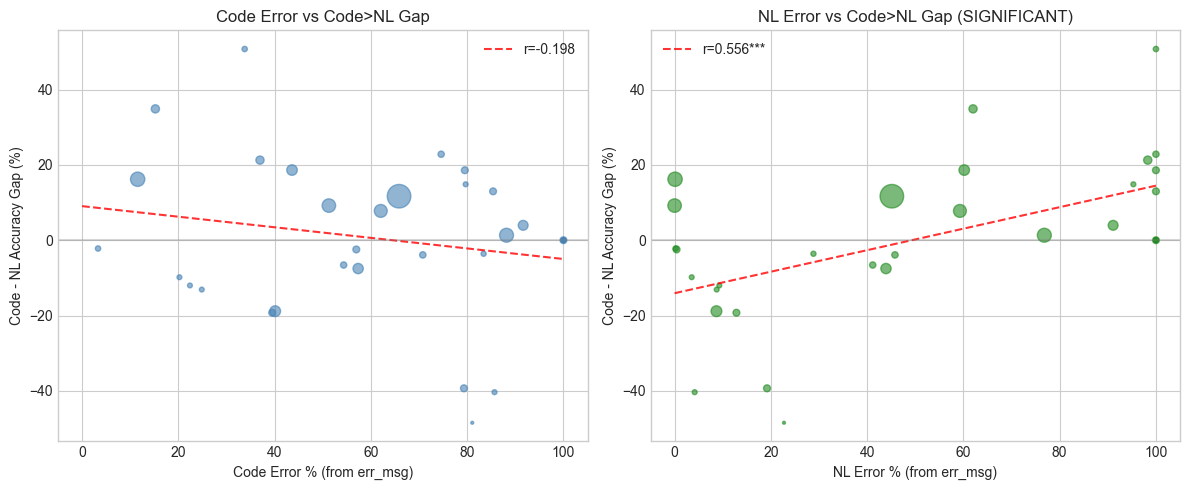

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: Code Error vs Code>NL
ax = axes[0]
ax.scatter(stats_df['code_err%'], stats_df['code_vs_nl'], s=stats_df['n']/30, alpha=0.6, c='steelblue')
z = np.polyfit(stats_df['code_err%'], stats_df['code_vs_nl'], 1)
x_line = np.linspace(0, 100, 100)
ax.plot(x_line, np.poly1d(z)(x_line), "r--", alpha=0.8, label=f'r={correlations["Code Err% vs Code>NL"]["r"]:.3f}')
ax.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
ax.set_xlabel('Code Error % (from err_msg)')
ax.set_ylabel('Code - NL Accuracy Gap (%)')
ax.set_title('Code Error vs Code>NL Gap')
ax.legend()

# Plot 2: NL Error vs Code>NL (SIGNIFICANT!)
ax = axes[1]
ax.scatter(stats_df['nl_err%'], stats_df['code_vs_nl'], s=stats_df['n']/30, alpha=0.6, c='forestgreen')
z = np.polyfit(stats_df['nl_err%'], stats_df['code_vs_nl'], 1)
ax.plot(x_line, np.poly1d(z)(x_line), "r--", alpha=0.8, label=f'r={correlations["NL Err% vs Code>NL"]["r"]:.3f}***')
ax.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
ax.set_xlabel('NL Error % (from err_msg)')
ax.set_ylabel('Code - NL Accuracy Gap (%)')
ax.set_title('NL Error vs Code>NL Gap (SIGNIFICANT)')
ax.legend()

plt.tight_layout()
plt.savefig('parse_error_correlation_corrected.png', dpi=150, bbox_inches='tight')
plt.show()

/var/folders/9r/1n_htmq5033c8l2dlp9vpgcm0000gn/T/ipykernel_52806/1180126835.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=stats_df, x='err_cat', y='code_vs_nl', order=order, palette=colors, ax=ax)


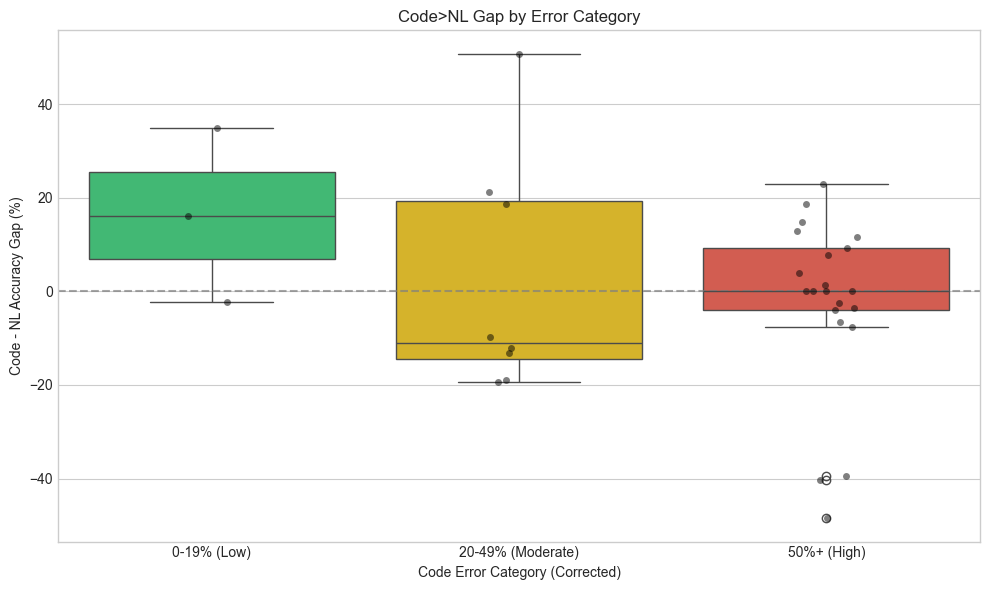

In [7]:
# Box plot by error category
def categorize_err(rate):
    if rate < 20: return '0-19% (Low)'
    elif rate < 50: return '20-49% (Moderate)'
    else: return '50%+ (High)'

stats_df['err_cat'] = stats_df['code_err%'].apply(categorize_err)

fig, ax = plt.subplots(figsize=(10, 6))
order = ['0-19% (Low)', '20-49% (Moderate)', '50%+ (High)']
colors = ['#2ecc71', '#f1c40f', '#e74c3c']

sns.boxplot(data=stats_df, x='err_cat', y='code_vs_nl', order=order, palette=colors, ax=ax)
sns.stripplot(data=stats_df, x='err_cat', y='code_vs_nl', order=order, color='black', alpha=0.5, ax=ax)

ax.axhline(y=0, color='gray', linestyle='--', alpha=0.7)
ax.set_xlabel('Code Error Category (Corrected)')
ax.set_ylabel('Code - NL Accuracy Gap (%)')
ax.set_title('Code>NL Gap by Error Category')

plt.tight_layout()
plt.savefig('parse_error_boxplot_corrected.png', dpi=150, bbox_inches='tight')
plt.show()

## Summary by Category

In [8]:
summary = stats_df.groupby('err_cat').agg({
    'model': 'count',
    'code_vs_nl': 'mean',
    'code_acc': 'mean',
    'nl_acc': 'mean'
}).round(1)
summary.columns = ['n_models', 'avg_code_vs_nl', 'avg_code_acc', 'avg_nl_acc']
summary

,n_models,avg_code_vs_nl,avg_code_acc,avg_nl_acc
err_cat,,,,
0-19% (Low),3,16.3,58.0,41.7
20-49% (Moderate),8,2.2,57.4,55.2
50%+ (High),21,-2.3,17.3,19.6


## Key Findings (Corrected)

In [9]:
print("="*80)
print("KEY FINDINGS (CORRECTED)")
print("="*80)

r_nl = correlations['NL Err% vs Code>NL']['r']
p_nl = correlations['NL Err% vs Code>NL']['p']
r_code = correlations['Code Err% vs Code>NL']['r']
p_code = correlations['Code Err% vs Code>NL']['p']

low_err_avg = stats_df[stats_df['code_err%'] < 20]['code_vs_nl'].mean()
high_err_avg = stats_df[stats_df['code_err%'] >= 50]['code_vs_nl'].mean()

print(f"""
1. SIGNIFICANT CORRELATION: NL Error% vs Code>NL
   r = {r_nl:+.3f}, p = {p_nl:.4f} ***
   Higher NL error → Higher Code>NL gap
   Interpretation: When NL fails, code can still work → Code advantage

2. NON-SIGNIFICANT: Code Error% vs Code>NL
   r = {r_code:+.3f}, p = {p_code:.4f}
   Code errors alone don't strongly predict the gap

3. BY ERROR CATEGORY:
   - Low code error (<20%):  avg Code>NL = {low_err_avg:+.1f}%
   - High code error (50%+): avg Code>NL = {high_err_avg:+.1f}%

4. BEST MODELS FOR CLEAN ANALYSIS (low code error <20%):
""")

low_err_models = stats_df[stats_df['code_err%'] < 20].sort_values('code_vs_nl', ascending=False)
for _, row in low_err_models.iterrows():
    print(f"   - {row['model']:<35} Code>NL: {row['code_vs_nl']:+.1f}%, Code Err: {row['code_err%']:.1f}%")

KEY FINDINGS (CORRECTED)

1. SIGNIFICANT CORRELATION: NL Error% vs Code>NL
   r = +0.556, p = 0.0010 ***
   Higher NL error → Higher Code>NL gap
   Interpretation: When NL fails, code can still work → Code advantage

2. NON-SIGNIFICANT: Code Error% vs Code>NL
   r = -0.198, p = 0.2779
   Code errors alone don't strongly predict the gap

3. BY ERROR CATEGORY:
   - Low code error (<20%):  avg Code>NL = +16.3%
   - High code error (50%+): avg Code>NL = -2.3%

4. BEST MODELS FOR CLEAN ANALYSIS (low code error <20%):

   - gemini-2.0-flash-001                Code>NL: +34.9%, Code Err: 15.2%
   - claude-haiku-4.5                    Code>NL: +16.2%, Code Err: 11.5%
   - x-ai/grok-4-fast                    Code>NL: -2.2%, Code Err: 3.3%


In [10]:
# Save
stats_df.to_csv('model_parse_error_stats_corrected.csv', index=False)
print("Saved to model_parse_error_stats_corrected.csv")

Saved to model_parse_error_stats_corrected.csv
